# Sensitivity shift fit model : for SI - To update new data ! TODO UPDATE SIGMA ! 

Sensitivity of model choices on shift fit model for reanalysis

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, statsmodels

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy.stats import norm

# import my variables settings functions from other scripts
from settings_ana import *
from functions_ana import *
from utils_ana import *
from plotscript import *

# # import other packages/modules 
# sys.path.append(os.path.join(os.environ['VSC_DATA_VO_USER'],'demographics4climate/'))
# from population_demographics import * 

sys.path.append('../dist_cov/dist_cov/')
import distributions as distributions


In [2]:
start_message()

flags: {'models': 'ISIMIP3b', 'experiment': None, 'metric': 'WBGT28', 'method': None, 'time_method': None, 'shift_sigma': False, 'shift_period': None, 'shift_loglike': None, 'chunk_version': None, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'EC-Earth3', 'UKESM1-0-LL', 'MPI-ESM1-2-HR', 'CNRM-ESM2-1']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
tim

In [3]:
from dask.distributed import Client 
client = Client()
client

/apps/brussel/RL8/zen4/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37011 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37011/status,
Dashboard: http://127.0.0.1:37011/status,Workers: 2
Total threads: 2,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39263,Workers: 2
Dashboard: http://127.0.0.1:37011/status,Total threads: 2
Started: Just now,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:39075,Total threads: 1
Dashboard: http://127.0.0.1:42613/status,Memory: 20.00 GiB
Nanny: tcp://127.0.0.1:40569,


In [4]:
figdir = os.path.join(figdirs, 'fig_feb25')

dir_shift_fit = 'forster2024-hitol-nan'


# Functions

In [5]:
def calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2022,GWI=1.3):

    gmst_pres = float(gmst_smo.loc[year_pres].iloc[0]) # take smoothed or not smoothed covariate ?? 
    gmst_pi = float(gmst_pres - GWI)

    b0 = da_params.sel(params='b0')
    b1 = da_params.sel(params='b1')


    if len(da_params.params) >3:
        sigma_b0 = da_params.sel(params='sigma_b0')
        sigma_b1 = da_params.sel(params='sigma_b1')
        norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0+sigma_b1*gmst_pi), norm(loc=b0+b1*gmst_pres, scale=sigma_b0+sigma_b1*gmst_pres)
    elif len(da_params.params) ==3:
        sigma_b0 = da_params.sel(params='sigma')
        norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0), norm(loc=b0+b1*gmst_pres, scale=sigma_b0)

    data = norm_pres.sf(threshold)
    da_p1 = xr.DataArray(
        data=data,
        dims=["dataset", "month", "lat", "lon", ],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )
    
    data = norm_pi.sf(threshold)
    da_p0 = xr.DataArray(
        data=data,
        dims=[ "dataset", "month", "lat", "lon"],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )

    days_in_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) # ignoring leap years

    # add dimension for correct multiplication
    days_in_month_da = xr.DataArray(days_in_month, dims=['month'], coords={'month': da_p1['month']})

    # calc nAHD per month and per year
    da_nAHD_mo = (da_p1 - da_p0) * days_in_month_da
    
    da_nAHD = da_nAHD_mo.sum(dim='month')


    return da_nAHD, da_nAHD_mo, da_p0, da_p1

In [6]:
def get_smoothed_gmst(ntime=4):
    df_gmst = pd.read_csv(os.path.join(datadirs,'gmst/gmst-obs/forster2024/annual_averages.csv')).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]
    gmst_smo = pd.DataFrame(apply_lowess(df_gmst, df_gmst.index, ntime=ntime))

    return gmst_smo

# Compare different models : 

## Prep data

In [7]:
flags['models']='ISIMIP3a'
dirname = 'output_shift-fit' 
dir_shift_fit = 'forster2024-hitol-nan' # to include the sigma models still !! 

da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 
                                      f'output_shift-fit-old/forster2024/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_sigma_mon_1901_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    
    da_params_lsl = xr.concat(da_list, dim="dataset") #loc sigma long


da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 
                                      f'output_shift-fit-old/forster2024/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_sigma_mon_1950_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    
    da_params_lss = xr.concat(da_list, dim="dataset") #loc sigma short



# once i have for other datasets also ! 

da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 
                                      f'output_shift-fit/{dir_shift_fit}/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc'))[0] # rename, these dont have loglike info !! 
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    
    da_params_ll = xr.concat(da_list, dim="dataset") #loc long


da_list = []


for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 
                                      f'output_shift-fit/{dir_shift_fit}/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_mon_1950_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    da_params_ls = xr.concat(da_list, dim="dataset") #loc long


In [8]:
gmst_smo = get_smoothed_gmst()

In [9]:
landmask = get_mask()

In [10]:
threshold = 28
year_pres = 2023 # for covariate fit
GWI=1.3

from scipy.stats import norm

In [11]:
da_nAHD_obs_lss, da_nAHD_mo_lss, da_p0_lss, da_p1_lss = calc_nAHD_shift_fit(da_params_lss, threshold, gmst_smo,year_pres=year_pres,GWI=1.3)
da_nAHD_obs_lsl, da_nAHD_mo_lsl, da_p0_lsl, da_p1_lsl = calc_nAHD_shift_fit(da_params_lsl, threshold, gmst_smo,year_pres=year_pres,GWI=1.3)

# lss = loc sigma short
# lsl = loc sigma long

In [12]:
da_nAHD_obs_ll, da_nAHD_mo_ll, da_p0_ll, da_p1_ll = calc_nAHD_shift_fit(da_params_ll, threshold, gmst_smo,year_pres=year_pres,GWI=1.3)
da_nAHD_obs_ls, da_nAHD_mo_ls, da_p0_ls, da_p1_ls = calc_nAHD_shift_fit(da_params_ls, threshold, gmst_smo,year_pres=year_pres,GWI=1.3)

# ll = loc long
# ls = loc short 

## figure

In [13]:
def plot_map_nAHD(data_plot,
                    ax,
                    proj=ccrs.PlateCarree(),
                    vmin = -100,
                    vmax = 200, 
                    levels = np.linspace(-100, 200, 16),
                    title_label = None,
                    title=True,
                  title_text=None,
                  cmap=None,
            ):

    if cmap=='skewed':
        cmap = LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    crs = ccrs.PlateCarree()
    ax.set_extent([-179.75, 179.75, -60, 90], crs=ccrs.PlateCarree())

    # plot
    plot = data_plot.plot(vmin=vmin, vmax=vmax, cmap=cmap, transform=crs, levels=levels, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    if title:
        if title_text is None:
            try: 
                ax.set_title(f'{data_plot.dataset.values}')
            except:
                ax.set_title(f'{data_plot.model.values}')
        else:
            ax.set_title(title_text)
    else:
        ax.set_title('')
            
    ax.set_title(title_label, loc='left',fontweight='bold')

    return plot 



With cbar from -200 to 200

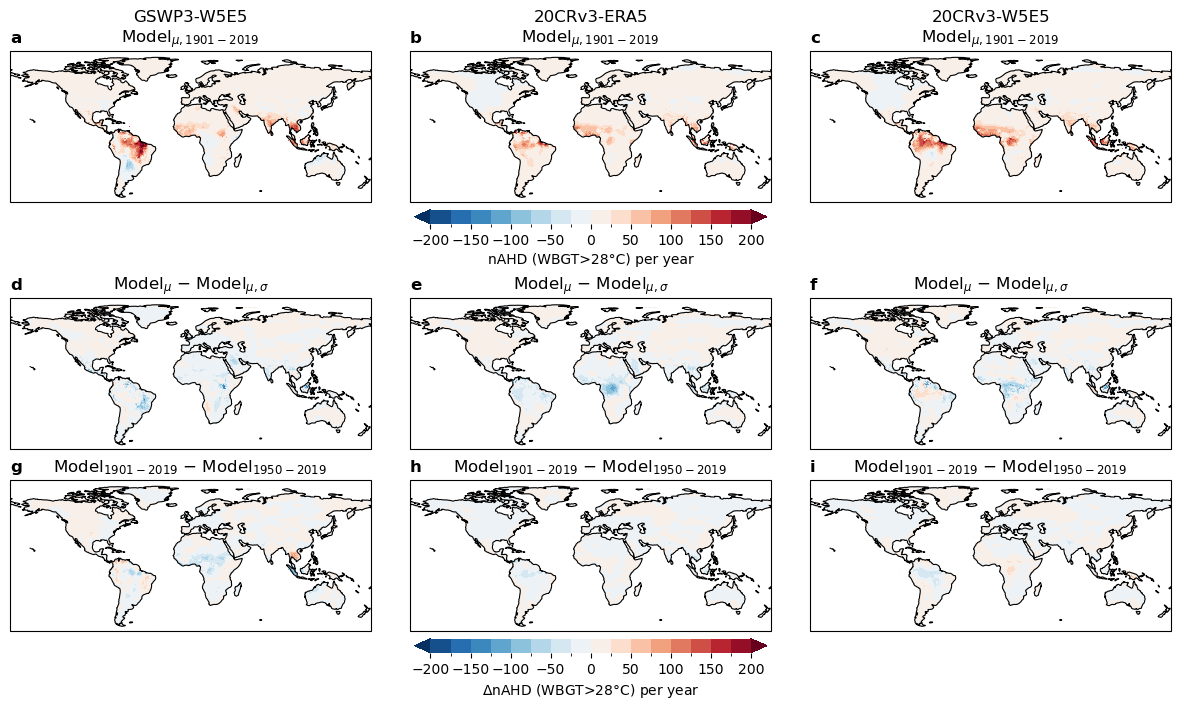

In [14]:
import string
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec


# Settings
proj = crs = ccrs.PlateCarree()
# cmap = LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
# vmin, vmax, levels = -100, 200, np.linspace(-100, 200, 16)

cmap = 'RdBu_r' #LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
vmin, vmax, levels = -200,200, 17 # np.linspace(-200, 200, 16)

#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Labels 
titles = [f"{letter}" for letter in string.ascii_lowercase[:13]]

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(5, 3, figure=fig)

# Plot observed data
for j in range(3):
    ax = fig.add_subplot(gs[0, j:j+1], projection=proj)
    data_plot = da_nAHD_obs_ll.isel(dataset=j) * landmask
    plot = plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j],
                 vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                 title_text=f'{data_plot.dataset.values}'+'\nModel$_{\mu,1901-2019}$' )

    if j==1:
        # Colorbar
        cbar = fig.colorbar(plot, extend='both', ax=ax, location='bottom', shrink=.9, fraction=0.12, aspect=25)
        cbar.set_label('nAHD (WBGT>28°C) per year', )
        cbar.outline.set_edgecolor('none')
        



for j in range(3):
    ax = fig.add_subplot(gs[1, j:j+1], projection=proj)
    data_plot = (da_nAHD_obs_ll-da_nAHD_obs_lsl).isel(dataset=j) * landmask
    plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j+3],
                  vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                  title_text='Model$_{\mu}$ $-$ Model$_{\mu, \sigma}$ '
                 )


for j in range(3):
    ax = fig.add_subplot(gs[2, j:j+1], projection=proj)
    data_plot = (da_nAHD_obs_ll-da_nAHD_obs_ls).isel(dataset=j) * landmask
    plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j+6],
                  vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                 title_text='Model$_{1901-2019}$ $-$ Model$_{1950-2019}$ ')

    if j==1:
        # Colorbar
        cbar = fig.colorbar(plot, extend='both', ax=ax, location='bottom', shrink=.9, fraction=0.12, aspect=25)
        cbar.set_label('$\Delta$nAHD (WBGT>28°C) per year', )
        cbar.outline.set_edgecolor('none')



# plt.savefig(os.path.join(figdir,'fig_SI_sensshiftfit.pdf'),dpi=300,transparent=True)
# plt.savefig(os.path.join(figdir,'fig_SI_sensshiftfit.png'),dpi=300,transparent=True)


Also -200,200 but now same cbar separation as other plots

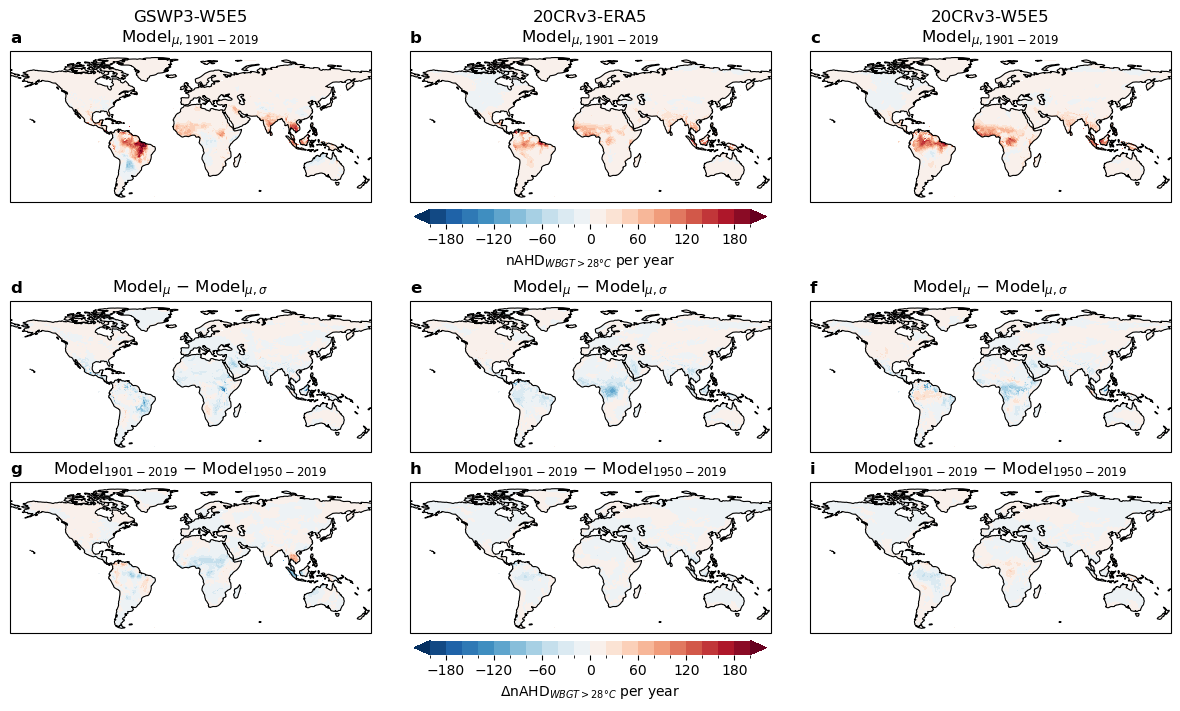

In [15]:
import string
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec


# Settings
proj = crs = ccrs.PlateCarree()
# cmap = LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
# vmin, vmax, levels = -100, 200, np.linspace(-100, 200, 16)

cmap = 'RdBu_r' #LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
vmin, vmax, levels = -200,200, 21 # np.linspace(-200, 200, 16)

#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Labels 
titles = [f"{letter}" for letter in string.ascii_lowercase[:13]]

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(5, 3, figure=fig)

# Plot observed data
for j in range(3):
    ax = fig.add_subplot(gs[0, j:j+1], projection=proj)
    data_plot = da_nAHD_obs_ll.isel(dataset=j) * landmask
    plot = plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j],
                 vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                 title_text=f'{data_plot.dataset.values}'+'\nModel$_{\mu,1901-2019}$' )

    if j==1:
        # Colorbar
        cbar = fig.colorbar(plot, extend='both', ax=ax, location='bottom', shrink=.9, fraction=0.12, aspect=25)
        cbar.set_label('nAHD$_{WBGT>28°C}$ per year', )
        cbar.outline.set_edgecolor('none')
        



for j in range(3):
    ax = fig.add_subplot(gs[1, j:j+1], projection=proj)
    data_plot = (da_nAHD_obs_ll-da_nAHD_obs_lsl).isel(dataset=j) * landmask
    plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j+3],
                  vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                  title_text='Model$_{\mu}$ $-$ Model$_{\mu, \sigma}$ '
                 )


for j in range(3):
    ax = fig.add_subplot(gs[2, j:j+1], projection=proj)
    data_plot = (da_nAHD_obs_ll-da_nAHD_obs_ls).isel(dataset=j) * landmask
    plot = plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j+6],
                  vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                 title_text='Model$_{1901-2019}$ $-$ Model$_{1950-2019}$ ')

    if j==1:
        # Colorbar
        cbar = fig.colorbar(plot, extend='both', ax=ax, location='bottom', shrink=.9, fraction=0.12, aspect=25)
        cbar.set_label('$\Delta$nAHD$_{WBGT>28°C}$ per year', )
        cbar.outline.set_edgecolor('none')



# plt.savefig(os.path.join(figdir,'fig_SI_sensshiftfit.pdf'),dpi=300,transparent=True)
# plt.savefig(os.path.join(figdir,'fig_SI_sensshiftfit.png'),dpi=300,transparent=True)




With different cbar for difference to better see it

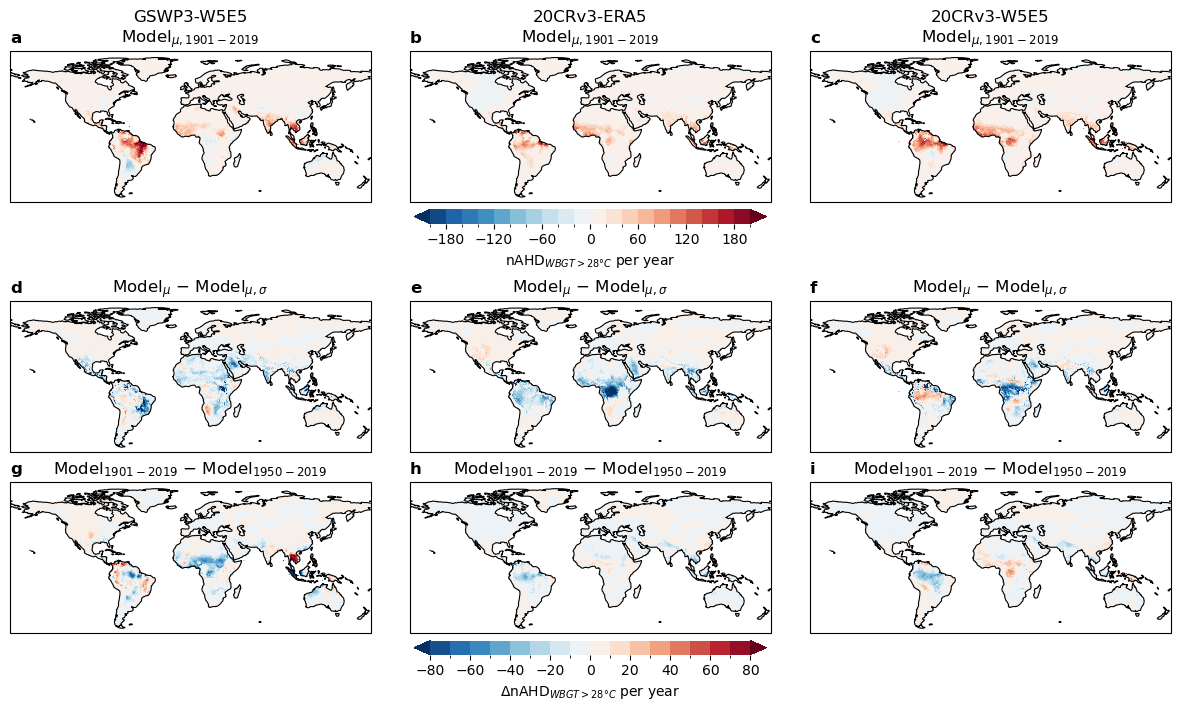

In [16]:
import string
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec


# Settings
proj = crs = ccrs.PlateCarree()
# cmap = LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
# vmin, vmax, levels = -100, 200, np.linspace(-100, 200, 16)

cmap = 'RdBu_r' #LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
vmin, vmax, levels = -200,200, 21 # np.linspace(-200, 200, 16)

#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Labels 
titles = [f"{letter}" for letter in string.ascii_lowercase[:13]]

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(5, 3, figure=fig)

# Plot observed data
for j in range(3):
    ax = fig.add_subplot(gs[0, j:j+1], projection=proj)
    data_plot = da_nAHD_obs_ll.isel(dataset=j) * landmask
    plot = plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j],
                 vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                 title_text=f'{data_plot.dataset.values}'+'\nModel$_{\mu,1901-2019}$' )

    if j==1:
        # Colorbar
        cbar = fig.colorbar(plot, extend='both', ax=ax, location='bottom', shrink=.9, fraction=0.12, aspect=25)
        cbar.set_label('nAHD$_{WBGT>28°C}$ per year', )
        cbar.outline.set_edgecolor('none')
        

vmin, vmax, levels = -80,80, 17

for j in range(3):
    ax = fig.add_subplot(gs[1, j:j+1], projection=proj)
    data_plot = (da_nAHD_obs_ll-da_nAHD_obs_lsl).isel(dataset=j) * landmask
    plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j+3],
                  vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                  title_text='Model$_{\mu}$ $-$ Model$_{\mu, \sigma}$ '
                 )


for j in range(3):
    ax = fig.add_subplot(gs[2, j:j+1], projection=proj)
    data_plot = (da_nAHD_obs_ll-da_nAHD_obs_ls).isel(dataset=j) * landmask
    plot = plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j+6],
                  vmin=vmin,vmax=vmax,cmap=cmap,levels=levels,
                 title_text='Model$_{1901-2019}$ $-$ Model$_{1950-2019}$ ')

    if j==1:
        # Colorbar
        cbar = fig.colorbar(plot, extend='both', ax=ax, location='bottom', shrink=.9, fraction=0.12, aspect=25)
        cbar.set_label('$\Delta$nAHD$_{WBGT>28°C}$ per year', )
        cbar.outline.set_edgecolor('none')



#plt.savefig(os.path.join(figdir,'fig_SI_sensshiftfit_v2.pdf'),dpi=300,transparent=True)
#plt.savefig(os.path.join(figdir,'fig_SI_sensshiftfit_v2.png'),dpi=300,transparent=True)
